**Clustering** 

**Importing the mandatory librairies**

In [1]:
import json
import numpy as np
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.cluster import KMeans
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.ensemble import RandomForestClassifier
!python -m spacy download en
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yassinhediger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yassinhediger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



    Linking successful
    /Users/yassinhediger/anaconda3/lib/python3.7/site-packages/en_core_web_sm
    -->
    /Users/yassinhediger/anaconda3/lib/python3.7/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



**Opening the data:**

We import data contained in two json files:



*   top_hits_lyrics.json
*   not_hits_lyrics.json



In [2]:
with open('../data/top_hits_lyrics.json') as json_file:
    top_hits_lyrics = json.load(json_file)
with open('../data/not_hits_lyrics.json') as json_file:
    not_hits_lyrics = json.load(json_file)


**We clean the data**

We re-use the method present in the classification notebook to clean the text

In [3]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
   
    # remove variations of Verse 1, VERSE 2, etc...
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = None
    return lyrics

**Json to Dataframe**

We transform Json encoded file to panda DataFrame. We apply the the method to clean the text. 

In [4]:
top_hits_df = pd.DataFrame(top_hits_lyrics)
top_hits_df['clean_lyrics'] = top_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
top_hits_df = top_hits_df[top_hits_df['source'].notnull()]
top_hits_df = top_hits_df[top_hits_df['clean_lyrics'].notnull()]

In [5]:
not_hits_df = pd.DataFrame(not_hits_lyrics)
not_hits_df['clean_lyrics'] = not_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
not_hits_df = not_hits_df[not_hits_df['source'].notnull()]
not_hits_df = not_hits_df[not_hits_df['clean_lyrics'].notnull()]

**Merging the Dataframes**

We merge not hit and hit Dataframe and we create a class coloumns to recognise from which dataframe the data comes

In [6]:
top_hits_df['class'] = 1
not_hits_df['class'] = 0
df = pd.concat([top_hits_df, not_hits_df])


**Tokenising the text**

We tokenise the text to be able to vectorize it then. It creates an Array with all the words. Each of them can this way be analysed separatly

In [7]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [8]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [9]:
X = df['clean_lyrics'] # the features we want to analyze
ylabels = df['class'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=72)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X_train_vec = v.fit_transform(X_train)
X_test_vec = v.fit_transform(X_train)

y_train

173     0
92      1
5900    0
6857    0
2645    0
3203    0
819     0
2475    0
7914    0
1092    1
9045    0
6511    0
8976    0
810     0
6297    0
1703    1
7492    0
7309    0
1083    0
5001    0
1265    0
2219    0
1464    1
2426    1
22      1
210     1
1201    0
2607    1
2609    1
7791    0
       ..
7575    0
5064    0
1254    1
5491    0
8077    0
790     0
1620    0
139     0
691     1
739     0
989     1
3660    0
3248    0
1762    0
467     1
4867    0
2035    1
329     0
468     1
1562    1
7108    0
6264    0
1792    1
5624    0
5785    0
86      0
6350    0
1224    0
5493    0
2684    0
Name: class, Length: 7519, dtype: int64

In [11]:
NUMBER_OF_CLUSTERS = 2
km = KMeans(
    n_clusters=NUMBER_OF_CLUSTERS, 
    init='k-means++', 
    max_iter=500)
km.fit(X_train_vec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
from sklearn.decomposition import PCA

# First: for every document we get its corresponding cluster
clusters = km.predict(X_train_vec)

# We train the PCA on the dense version of the tf-idf. 
pca = PCA(n_components=2)
two_dim = pca.fit_transform(X_train_vec.todense())

scatter_x = two_dim[:, 0] # first principle component
scatter_y = two_dim[:, 1] # second principle component

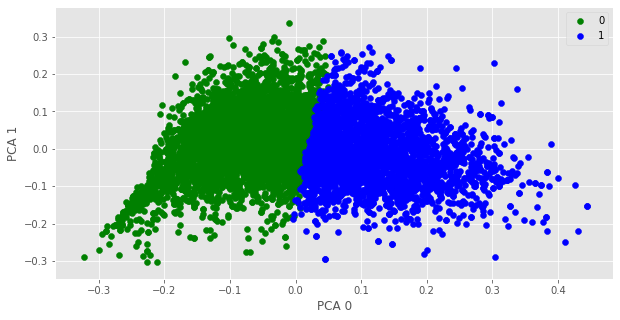

In [13]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# color map for NUMBER_OF_CLUSTERS we have
cmap = {0: 'green', 1: 'blue'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

Text(0.5, 1.0, 'ground truth')

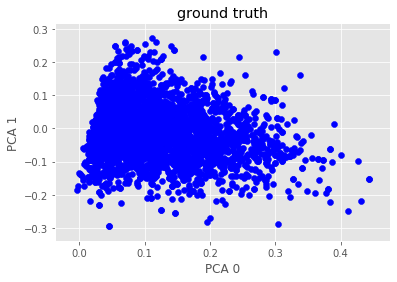

In [14]:
plt.scatter(scatter_x[ix], scatter_y[ix],
               c=cmap[group], label=group)
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.title('ground truth')

In [15]:
est = KMeans(n_clusters=3)
est.fit(X_train_vec, y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [16]:
est.labels_

array([2, 2, 2, ..., 2, 1, 2], dtype=int32)

In [17]:
y_train.values

array([0, 1, 0, ..., 0, 0, 0])

In [18]:
# how accurate are the kmeans labels
sum([1 if x else 0 for x in (est.labels_ == y_train.values)]) / len(est.labels_)

0.29578401383162656

In [19]:
from sklearn.cluster import AgglomerativeClustering

In [20]:
%%time
clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(X_train_vec.toarray(), y_train.values)


CPU times: user 14min 57s, sys: 1.81 s, total: 14min 59s
Wall time: 14min 59s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3,
                        pooling_func='deprecated')

In [21]:
clustering.labels_

array([1, 2, 2, ..., 2, 2, 2])

In [22]:
y_train.values

array([0, 1, 0, ..., 0, 0, 0])

In [23]:
reordered_target = np.zeros(len(y_train.values))
reordered_target[np.where(y_train.values==0)[0]] = 1
reordered_target[np.where(y_train.values==1)[0]] = 2
reordered_target

array([1., 2., 1., ..., 1., 1., 1.])

In [24]:
sum([1 if x else 0 for x in (clustering.labels_ == reordered_target)]) / len(clustering.labels_)

0.36454315733475195

In [ ]:
import scipy #scientific computations
from scipy.cluster.hierarchy import dendrogram, linkage #hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

Z = linkage(X_train_vec.toarray(),'ward') #linkage: single, average, complete
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Number of points in node (or index of point if no parenthesis)', fontsize=20)
plt.ylabel('distance', fontsize=20)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.)   # font size for the x axis labels
plt.show()